C:\Users\msneh\AppData\Local\Temp\ipykernel_15560\852376099.py:68: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=TRAIN_START, progress=False)
C:\Users\msneh\AppData\Local\Temp\ipykernel_15560\852376099.py:68: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=TRAIN_START, progress=False)
C:\Users\msneh\AppData\Local\Temp\ipykernel_15560\852376099.py:68: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=TRAIN_START, progress=False)
C:\Users\msneh\AppData\Local\Temp\ipykernel_15560\852376099.py:68: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=TRAIN_START, progress=False)
C:\Users\msneh\AppData\Local\Temp\ipykernel_15560\852376099.py:68: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, 

Data ready for 49 companies.
Preparing Global Training Data...
Training LSTM Model...


C:\Users\msneh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
856/856 ━━━━━━━━━━━━━━━━━━━━ 76s 82ms/step - loss: 0.0027 - val_loss: 4.0831e-04
Epoch 2/2
856/856 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - loss: 3.7430e-04 - val_loss: 2.7855e-04
Training XGBoost Model...
Models Trained Successfully.

Starting 'Alpha-Seeker' Trading Simulation (2025)...
--------------------------------------------------
FINAL RESULTS (2025 Paper Trading)
--------------------------------------------------
Initial Capital: ₹1,000,000
Final Value:     ₹1,244,960.05
Net Profit:      ₹244,960.05
ROI:             24.50%
--------------------------------------------------


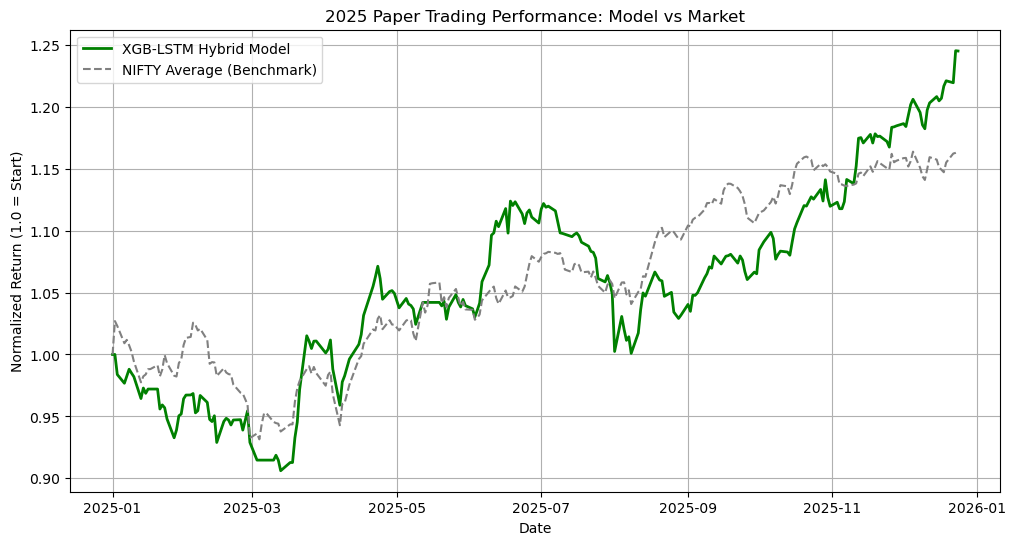

In [13]:
# !pip install yfinance pandas numpy scikit-learn xgboost tensorflow matplotlib

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# ==========================================
# 1. CONFIGURATION & TICKERS
# ==========================================
# Top 50 NIFTY Tickers (Using Yahoo Finance .NS suffix)
NIFTY_50 = [
    "RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", 
    "HINDUNILVR.NS", "ITC.NS", "SBIN.NS", "BHARTIARTL.NS", "LICI.NS",
    "KOTAKBANK.NS", "LT.NS", "BAJFINANCE.NS", "HCLTECH.NS", "ASIANPAINT.NS",
    "AXISBANK.NS", "MARUTI.NS", "TITAN.NS", "SUNPHARMA.NS", "ULTRACEMCO.NS",
    "NTPC.NS", "POWERGRID.NS", "TATASTEEL.NS", "BAJAJFINSV.NS", "M&M.NS",
    "NESTLEIND.NS", "ADANIENT.NS", "INDUSINDBK.NS", "JSWSTEEL.NS", "GRASIM.NS",
    "TECHM.NS", "CIPLA.NS", "ADANIPORTS.NS", "WIPRO.NS", "HINDALCO.NS",
    "ONGC.NS", "SBILIFE.NS", "DRREDDY.NS", "BRITANNIA.NS", "TATACONSUM.NS",
    "COALINDIA.NS", "APOLLOHOSP.NS", "EICHERMOT.NS", "DIVISLAB.NS", "TATAMOTORS.NS",
    "BPCL.NS", "HEROMOTOCO.NS", "UPL.NS", "SHRIRAMFIN.NS"
]

TRAIN_START = "2018-01-01"
TRAIN_END = "2024-12-31"
TEST_START = "2025-01-01"  # Paper Trading Period
LOOKBACK = 60  # Time steps for LSTM

# ==========================================
# 2. DATA DOWNLOAD & TECHNICAL INDICATORS
# ==========================================
def add_indicators(df):
    df = df.copy()
    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Moving Averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # Volatility / Momentum
    df['Pct_Change'] = df['Close'].pct_change()
    
    df.dropna(inplace=True)
    return df

print("Downloading and processing data (this may take a moment)...")
data_store = {}
for ticker in NIFTY_50:
    try:
        df = yf.download(ticker, start=TRAIN_START, progress=False)
        if len(df) > 200:
            df = add_indicators(df)
            data_store[ticker] = df
    except Exception as e:
        print(f"Failed {ticker}: {e}")

print(f"Data ready for {len(data_store)} companies.")

# ==========================================
# 3. GLOBAL MODEL TRAINING (HYBRID)
# ==========================================
# We train ONE model on ALL stocks to learn general market patterns (prevents overfitting)

X_train_global, y_train_global = [], []
scalers = {} # Keep a scaler for each stock to inverse transform later

print("Preparing Global Training Data...")
for ticker, df in data_store.items():
    # Split into Train (upto 2024)
    train_data = df[df.index <= TRAIN_END].copy()
    
    if len(train_data) < LOOKBACK: continue
    
    # Scale Features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train_data[['Close', 'RSI', 'MACD', 'SMA_20', 'Volume']])
    scalers[ticker] = scaler
    
    # Create Sequences
    for i in range(LOOKBACK, len(scaled_data)):
        X_train_global.append(scaled_data[i-LOOKBACK:i])
        y_train_global.append(scaled_data[i, 0]) # Predict Close

X_train_global, y_train_global = np.array(X_train_global), np.array(y_train_global)

# Split 70:30 for internal validation (as requested)
split_idx = int(len(X_train_global) * 0.70)
X_train, X_val = X_train_global[:split_idx], X_train_global[split_idx:]
y_train, y_val = y_train_global[:split_idx], y_train_global[split_idx:]

# --- Model A: LSTM ---
print("Training LSTM Model...")
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, batch_size=64, epochs=2, validation_data=(X_val, y_val), verbose=1)

# --- Model B: XGBoost ---
print("Training XGBoost Model...")
# Flatten LSTM input for XGBoost (Sequence -> Flat Vector)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_flat, y_train)

print("Models Trained Successfully.")

# ==========================================
# ==========================================
# 4. PAPER TRADING ENGINE (SMART ALPHA VERSION)
# ==========================================
class PaperTrader:
    def __init__(self, initial_capital=1000000):
        self.cash = initial_capital
        self.holdings = {} 
        self.history = []
        self.portfolio_value = []
        self.dates = []
    
    def get_portfolio_value(self, date, prices):
        val = self.cash
        for ticker, qty in self.holdings.items():
            if ticker in prices:
                val += qty * prices[ticker]
        return val

    def rebalance(self, date, recommendations, current_prices):
        # 1. Sell Loop
        for ticker, qty in list(self.holdings.items()):
            if ticker in current_prices:
                revenue = qty * current_prices[ticker]
                self.cash += revenue
        self.holdings = {}
        
        # 2. Buy Loop (Top 10 High Conviction)
        if not recommendations: return
        
        # Allocate 10% capital to each of the top 10 picks
        allocation_per_stock = self.cash / len(recommendations)
        
        for ticker in recommendations:
            if ticker in current_prices:
                price = current_prices[ticker]
                qty = int(allocation_per_stock / price)
                if qty > 0:
                    self.holdings[ticker] = qty
                    self.cash -= qty * price

# Setup Backtest
trader = PaperTrader(initial_capital=1000000)
market_benchmark = []

# Generate trading dates for 2025
start_date = datetime(2025, 1, 1)
end_date = datetime.now()
current_date = start_date

print("\nStarting 'Alpha-Seeker' Trading Simulation (2025)...")

while current_date <= end_date:
    # Basic date validation
    sample_df = data_store[NIFTY_50[0]]
    if current_date not in sample_df.index:
        current_date += timedelta(days=1)
        continue
        
    day_name = current_date.strftime("%A")
    is_rebalance_day = day_name in ["Monday", "Thursday"]
    
    # --- ROBUST PRICE EXTRACTION ---
    current_prices = {}
    current_technicals = {} # Store tech indicators for filtering
    
    for t, df in data_store.items():
        if current_date in df.index:
            try:
                # 1. Get Price
                price_val = df.loc[current_date]['Close']
                if isinstance(price_val, pd.Series): price_val = price_val.item()
                current_prices[t] = float(price_val)
                
                # 2. Get Indicators for Filtering
                sma_50 = df.loc[current_date]['SMA_50']
                macd = df.loc[current_date]['MACD']
                sig = df.loc[current_date]['Signal_Line']
                
                # Handle Series ambiguity for indicators too
                if isinstance(sma_50, pd.Series): sma_50 = sma_50.item()
                if isinstance(macd, pd.Series): macd = macd.item()
                if isinstance(sig, pd.Series): sig = sig.item()
                
                current_technicals[t] = {'SMA_50': sma_50, 'MACD': macd, 'Signal': sig}
                
            except Exception:
                continue
    
    if not current_prices:
        current_date += timedelta(days=1)
        continue

    # --- STRATEGY LOGIC ---
    if is_rebalance_day:
        predictions = []
        
        for ticker in data_store.keys():
            if ticker not in current_prices: continue
            
            df = data_store[ticker]
            past_data = df[df.index < current_date]
            
            if len(past_data) < LOOKBACK: continue
            
            # Prepare Input
            raw_seq = past_data[['Close', 'RSI', 'MACD', 'SMA_20', 'Volume']].tail(LOOKBACK).values
            if len(raw_seq) != LOOKBACK: continue
            
            scaler = scalers.get(ticker)
            if not scaler: continue
            
            seq_scaled = scaler.transform(raw_seq)
            
            # Hybrid Prediction
            lstm_pred = lstm_model.predict(seq_scaled.reshape(1, LOOKBACK, 5), verbose=0)[0][0]
            xgb_pred = xgb_model.predict(seq_scaled.reshape(1, -1))[0]
            avg_scaled_pred = (lstm_pred + xgb_pred) / 2
            
            # Get Predicted Price
            dummy_vec = np.zeros((1, 5))
            dummy_vec[0, 0] = avg_scaled_pred
            pred_price = scaler.inverse_transform(dummy_vec)[0, 0]
            
            curr_price = current_prices[ticker]
            techs = current_technicals.get(ticker, {})
            
            # --- SUPERIOR FILTERING LOGIC ---
            # 1. Prediction must be positive
            if pred_price > curr_price:
                # 2. TREND FILTER: Price must be above 50-day Moving Average (Uptrend)
                if curr_price > techs.get('SMA_50', 0):
                    # 3. MOMENTUM FILTER: MACD must be above Signal Line
                    if techs.get('MACD', 0) > techs.get('Signal', 0):
                        
                        expected_return = (pred_price - curr_price) / curr_price
                        predictions.append((ticker, expected_return))
        
        # Sort by highest predicted return
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        # CONCENTRATION: Pick Top 10 only (High Conviction)
        top_picks = [p[0] for p in predictions[:10]]
        
        trader.rebalance(current_date, top_picks, current_prices)

    # Track Performance
    port_val = trader.get_portfolio_value(current_date, current_prices)
    trader.portfolio_value.append(port_val)
    trader.dates.append(current_date)
    
    # Track Benchmark (NIFTY Average)
    avg_mkt_price = np.mean(list(current_prices.values()))
    market_benchmark.append(avg_mkt_price)
    
    current_date += timedelta(days=1)      
   
# ==========================================
# 5. ANALYSIS & VISUALIZATION
# ==========================================
# Normalize for plotting
model_returns = np.array(trader.portfolio_value) / trader.portfolio_value[0]
market_returns = np.array(market_benchmark) / market_benchmark[0]

final_profit = (trader.portfolio_value[-1] - 1000000)
roi = (final_profit / 1000000) * 100

print("-" * 50)
print(f"FINAL RESULTS (2025 Paper Trading)")
print("-" * 50)
print(f"Initial Capital: ₹1,000,000")
print(f"Final Value:     ₹{trader.portfolio_value[-1]:,.2f}")
print(f"Net Profit:      ₹{final_profit:,.2f}")
print(f"ROI:             {roi:.2f}%")
print("-" * 50)

plt.figure(figsize=(12, 6))
plt.plot(trader.dates, model_returns, label='XGB-LSTM Hybrid Model', color='green', linewidth=2)
plt.plot(trader.dates, market_returns, label='NIFTY Average (Benchmark)', color='gray', linestyle='--')
plt.title('2025 Paper Trading Performance: Model vs Market')
plt.xlabel('Date')
plt.ylabel('Normalized Return (1.0 = Start)')
plt.legend()
plt.grid(True)
plt.show()